# Classification of American Sign Language
### Harshit Aggarwal 
### RA1911003010782

Dataset: https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models



In [2]:
torch.cuda.is_available()

True

## Defining Pytorch Dataset and Dataloader:

In [8]:
train = pd.read_csv('/content/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test.csv')

In [9]:
class SignLanguageDataset(data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label
        

In [10]:
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [11]:
transforms4train = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
]) 

In [12]:
train_dataset = SignLanguageDataset(train, transform=transforms4train)
test_dataset = SignLanguageDataset(test)

In [13]:
len(train_dataset), len(test_dataset)

(27455, 7172)

In [14]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

In [15]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(10)


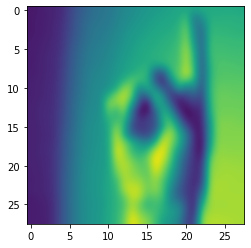

In [16]:
show_img(img[10], label[10])

In [17]:
def calc_out_size(img_size, kernel_size, stride=1, padding=1, dilation=1 ):
    out_size = ((img_size + 2*padding - (dilation*(kernel_size-1) +1 )) / stride) + 1
    return int(out_size)

In [18]:
calc_out_size(28, 3)

28

## Making simple custom convolution net:

In [19]:
class MyConvNet(nn.Module):
    
    def __init__(self, stride=1, dilation=1, n_classes=25):
        
        super(MyConvNet, self).__init__()
        
        self.stride = stride
        self.dilation = dilation
        self.n_classes = n_classes
        
        self.block1 = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
        )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x

In [20]:
model = MyConvNet()
model

MyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=100, out_features=25, bias=True)
)

In [21]:
sample_batch = torch.ones(20, 1, 28, 28)
print(model.block1(sample_batch).shape)
print(model.block2(model.block1(sample_batch)).shape)
print(model(sample_batch).shape)

torch.Size([20, 8, 14, 14])
torch.Size([20, 16, 7, 7])
torch.Size([20, 25])


## Defining our training and evaluation pipeline:

In [22]:
def eval_model(model, criterion, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_loader:
        
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy
        
        

In [23]:
def train_model(n_epochs, model, optimizer, criterion, train_loader, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            
            
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc        
        
        

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [25]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (14.2901 s.): train loss - 0.010675240308046341, train accuracy - 0.38798033145146604; test loss - 0.005127804819494486, test accuracy - 0.7073340769659788
EPOCH 1 (14.2259 s.): train loss - 0.004896213766187429, train accuracy - 0.7223092332908395; test loss - 0.0026465870905667543, test accuracy - 0.8205521472392638
EPOCH 2 (14.1573 s.): train loss - 0.0032905463594943285, train accuracy - 0.8116554361682754; test loss - 0.0019050601404160261, test accuracy - 0.8831567205800335
EPOCH 3 (14.2033 s.): train loss - 0.0026896754279732704, train accuracy - 0.8417046075396103; test loss - 0.002152571687474847, test accuracy - 0.8653095370886782
EPOCH 4 (14.1554 s.): train loss - 0.0023171259090304375, train accuracy - 0.8606446913130578; test loss - 0.0020003621466457844, test accuracy - 0.8696319018404908
EPOCH 5 (14.1198 s.): train loss - 0.0021157539449632168, train accuracy - 0.8702604261518849; test loss - 0.001713134115561843, test accuracy - 0.8984941438929169
EPOCH 6 (14.06

Text(0.5, 1.0, 'Accuracy')

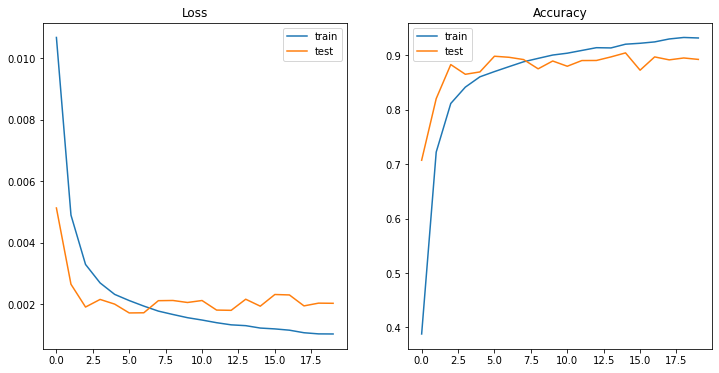

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [27]:
state = {'model': model.state_dict(),
        'epoch': 20}
torch.save(state, './myconvnet_sign_lang.pth')

In [28]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 12, Prediction: 13
tensor(12)


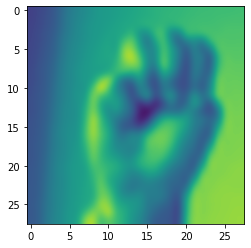

In [29]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

## Using ready ResNet18 architecture (with additional layers to match desired input and output sizes)

In [30]:
resnet18 = models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
resnet18.fc = nn.Linear(in_features=512, out_features=25) 

In [32]:
resnet18_1channel = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1), 
                                resnet18)

In [33]:
smpl = torch.ones((10, 1, 28, 28))
resnet18_1channel(smpl).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([10, 25])

In [34]:
optimizer = optim.Adam(resnet18_1channel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [35]:
model, train_loss, train_acc, test_loss, test_acc = train_model(30, resnet18_1channel, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (18.1212 s.): train loss - 0.0041451104916632175, train accuracy - 0.7525405208523037; test loss - 0.0018121289322152734, test accuracy - 0.8819018404907976
EPOCH 1 (18.0476 s.): train loss - 0.015466601587831974, train accuracy - 0.14729557457657985; test loss - 0.008730575442314148, test accuracy - 0.39472950362520914
EPOCH 2 (18.1359 s.): train loss - 0.006898985244333744, train accuracy - 0.553268985612821; test loss - 0.003999494947493076, test accuracy - 0.7279698828778584
EPOCH 3 (18.1649 s.): train loss - 0.003673792351037264, train accuracy - 0.7684574758696048; test loss - 0.002044738968834281, test accuracy - 0.9023982152816509
EPOCH 4 (18.0725 s.): train loss - 0.0027548742946237326, train accuracy - 0.8258969222363868; test loss - 0.0020877476781606674, test accuracy - 0.9089514779698828
EPOCH 5 (18.1976 s.): train loss - 0.0024189797695726156, train accuracy - 0.8439628482972136; test loss - 0.00210236432030797, test accuracy - 0.9015616285554936
EPOCH 6 (18.1331 

Text(0.5, 1.0, 'Accuracy')

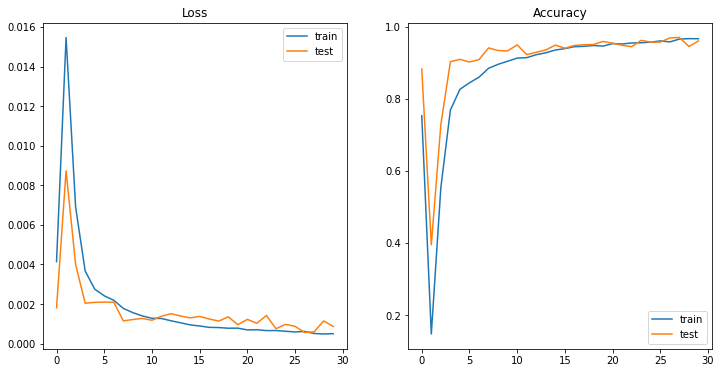

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [37]:
state = {'model': model.state_dict(),
        'epoch': 20}
torch.save(state, './myconvnet_sign_lang.pth')

In [38]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 1, Prediction: 1
tensor(1)


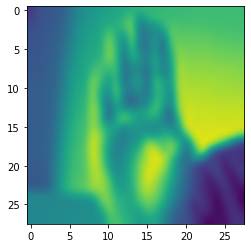

In [39]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

# Thus we get 95.9% validation accuracy by combining two architectures